## Main message
One of the most important steps in optimization is formulating well-posed and meaningful problems that you can interpret accurately. 

## The objective function
The objective is the measure that you are trying to minimize or maximize when performing optimization. Common objective functions include performance and cost metrics. You might be trying to [minimize the cost of energy produced by a wind turbine](https://doi.org/10.1016/j.renene.2014.02.045) or [maximize the bushels of corn and soybeans produced on a piece of farmland](https://doi.org/10.1016/j.agsy.2014.02.002). Whatever your objective is, you need to quantify and model it in some way so the optimizer can find the optima.

In general, you need your objective function to output a singular scalar value, though you can also perform [[Multiobjective optimization]]. If you're using gradient-based optimizers, your objective function should be smooth and differentiable.

Most representations of optimization problems seek to minimize the objective function so that the math is always the same. OpenMDAO assumes this as well, but if you want to maximize a value you can apply a `scaler` or `ref` using a negative value (such as -1), which will flip the minimization problem into a maximization problem.

An objective function is a type of a "function of interest," along with constraints.

In a general sense, an optimization problem looks like this when written formally:

$$
\begin{align*}
\text{Minimize} & \quad f_{\text{obj}}(x) \\
\text{With respect to design variables} & \quad x \\
\text{Subject to constraints} & \quad g_{\text{lb}} \leq g(x) \leq g_{\text{ub}} \\
 & \quad h(x) = h_{\text{eq}} \\
\end{align*}
$$

## Design variables
Design variables are any value that are being controlled by the optimizer. Design variables (DVs) often control the geometric, operational, or physical aspects of systems. Finding the optimal set of design variables for a given problem means that you have solved it. DVs can have any arbitrary shape and size, though optimization problems become more difficult to solve as the design space grows in dimensionality.

In the most general sense, DVs can be "continuous" where they can take any number of infinite values between bounds, or "discrete" where only certain values or types are allowed. Examples of continuous design variables include any floating point number or value, such as thickness of a structural member, capacity of batteries, or twist of an airplane wing section. Discrete variables include the number of blades on a wind turbine, the number of passengers on a flight, or number of motors on a wing.

When solving a new optimization problem, you should use the smallest number of DVs you can and still have an interesting problem. You might want to throw the whole kitchen sink at the optimizer where you have all the DVs that you'd eventually want optimized, but that approach often results in optimizer non-convergence or non-sensical answers. It often pays to walk before you run and slowly build up the complexity of the optimization problems, solving each more complex problem consecutively.

When choosing what should be a design variable, you should avoid linearly dependent variables. What we mean by that is that if you have multiple DVs that essentially control the same physical system, you should remove some of those DVs. For example, if you are modeling an aircraft wing and have angle of attack (AoA) *and* twist all the way across the wing, there are infinite combinations of AoA and twist that result in numerically the same condition. Here, you would constrain the root twist of the wing to avoid this unnecessary complication in the design space.

If you're solving a problem with a large number of DVs, you should use gradient-based optimization as detailed in [[Why to use gradient-based optimizers]]. Gradient-based optimizers scale much better with number of design variables, and if your analysis cost is non-trivial, this quickly becomes the only viable way to perform optimization.

Bounds on design variables will be respected by optimizers. This means that in most all cases, the optimizer will never query the model outside of the bounded design variable space. This is not always the case for constraints.


## Constraints
A constraint is another type of a "function of interest," alongside objective functions. A constraint is a way to limit the outputted values of a model by using an optimizer. Any value outputted by the model can be used as a constraint.

There are a few different categories of constraints.

Inequality constraints dictate that an outputted value from a model must be greater than or less than a desired constraint value. Equality constraints dictate that the outputted value must match the desired value to a certain tolerance.

When all constraints are satisfied, the corresponding design is said to be "feasible". If any constraint is not satisfied, the design is "infeasible". At the a given design point, if a constraint value is right on its bound (either upper or lower bound), it is said to be an "active" constraint. Otherwise, if the constraint has more wiggle room at a design point, it is an "inactive" constraint.

While solving an optimization problem, the optimizer can violate prescribed constraints, unlike design variable bounds. This is normal and gives the optimizer more freedom to move through the design space. For example, there might be multiple feasible regions within the design space and only by temporarily violating a constraint can the optimizer move between them. Hopefully, if the optimization converges successfully, all constraints are satisfied at the optimal design.

## Basic tips for formulating optimization problems
If we could write out all the tips you need to create and solve complex optimization problems, that'd be fantastic. Unfortunately, there are so many details and intricacies -- this entire course is basically about this topic. However, we can discuss the extreme basics here and get you started solving relevant problems for your models.

First of all, the guidance in this section assumes you already have a working model, have verified it and its gradients, and somewhat understand the design space. None of those items are trivial by themselves, but all of them are necessary to perform gradient-based optimization.

To reiterate, you want to start with the simplest optimization problem that is reasonable for you to solve. If you're doing an aircraft mission optimization, start with a steady-state cruise profile. If you want to find the optimal aircraft wing structure, start with a 1g flight condition in steady flight and control just a few design variables. You want to simplify both the optimization problem and the complexity of the analyses to minimize potential sources of trouble.

Then, run a few iterations of the optimization algorithm to see what happens. Make sure the optimizer is taking reasonable steps and progressing through the design space. If the model analysis fails, examine what caused the failure and create a failsafe condition accordingly. Optimizers often push models beyond what designers might think is reasonable. If your model has some small bug or inconsistency, optimizers do a great job of finding those.

After you've run a few iterations of the optimization problem, refine the problem if need be and now run an optimization to convergence. You can then postprocess the results and see if it matches your intuition. if it doesn't, determine the physical reasoning behind the results and see if you should add or remove constraints, design variables, or change the objective function.

Next you need to iterate on the problem formulation and continue solving more complex problems. Only by interpreting and reformulating optimization problems and results can you get to meaningful answers. A push-button solution for optimization is not possible -- it requires people like you, the practitioner, to use your expertise to interpret the results.

We will cover many more tips in the [[Advanced problem formulation]] section, including deciding when to add a constraint vs. having the analysis solve for the value, how to determine the correct parameterization for a design space, and what makes poorly and well-defined optimization problems.

## Example 2D Optimization

We now optimize on the [Himmelblau Function](https://en.wikipedia.org/wiki/Himmelblau%27s_function) to showcase how to perform unconstrained and constrained optimization. This function has four minima and one maximum within the design space.

Here is a contour plot of the function.

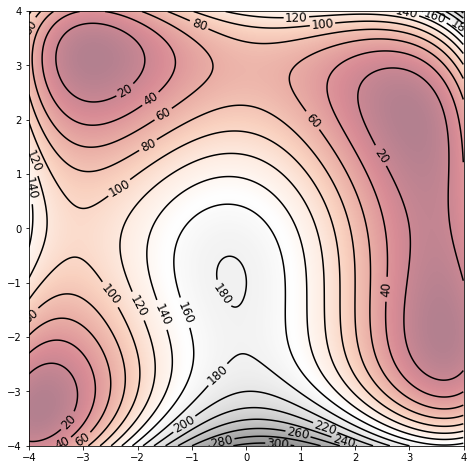

In [7]:
import numpy as np
import matplotlib.pyplot as plt


# objective function
def objective(x, y):
    return (x**2 + y - 11)**2 + (x + y**2 -7)**2

r_min, r_max = -4., 4.
xaxis = np.arange(r_min, r_max, 0.01)
yaxis = np.arange(r_min, r_max, 0.01)
x, y = np.meshgrid(xaxis, yaxis)
results = objective(x, y)

plt.figure(figsize=(10, 8))
contours = plt.contour(x, y, results, 15, colors='black')
plt.clabel(contours, inline=True, fontsize=12)
plt.imshow(results, extent=[r_min, r_max, r_min, r_max], origin='lower', cmap='RdGy', alpha=0.5)
ax = plt.gca()
plt.show()

We first perform unconstrained optimization using SLSQP.

In [1]:
import numpy as np
import openmdao.api as om


excomp = om.ExecComp('obj=(x**2 + y - 11)**2 + (x + y**2 -7)**2')

prob = om.Problem()

prob.model.add_subsystem('excomp', excomp, promotes=['*'])

# setup the optimization
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'
prob.driver.options['tol'] = 1.e-9

prob.driver.recording_options['includes'] = ['*']
recorder = om.SqliteRecorder("unconstrained.sql")
prob.driver.add_recorder(recorder)

prob.model.add_design_var('x', lower=-4., upper=4.)
prob.model.add_design_var('y', lower=-4., upper=4.)
prob.model.add_objective('obj')

prob.setup()

# run the optimization
prob.run_driver();

/home/john/anaconda3/envs/course/lib/python3.8/site-packages/openmdao/recorders/sqlite_recorder.py:227: UserWarning:The existing case recorder file, unconstrained.sql, is being overwritten.


Optimization terminated successfully    (Exit mode 0)
            Current function value: 4.821594231924909e-11
            Iterations: 8
            Function evaluations: 11
            Gradient evaluations: 8
Optimization Complete
-----------------------------------


Then we write a short helper function to help us postprocess results.

In [2]:
def get_results(filename):
    cr = om.CaseReader(filename)
    cases = cr.get_cases()

    results = {}
    for case in cases:
        for key in case.outputs.keys():
            if key not in results.keys():
                results[key] = []
            results[key].append(case.outputs[key])

    for key in case.outputs.keys():
        results[key] = np.array(results[key])

    return results

results = get_results("unconstrained.sql")
print(results)

{'x': array([[1.        ],
       [1.        ],
       [4.        ],
       [1.95454545],
       [4.        ],
       [2.59872122],
       [4.        ],
       [2.92430033],
       [3.04354959],
       [2.99815529],
       [2.99997032],
       [2.99999961]]), 'y': array([[1.        ],
       [1.        ],
       [4.        ],
       [1.95454545],
       [2.90453522],
       [2.25372608],
       [0.8053446 ],
       [1.91720293],
       [2.0096556 ],
       [2.00016485],
       [1.99997846],
       [2.00000183]]), 'obj': array([[1.06000000e+02],
       [1.06000000e+02],
       [2.50000000e+02],
       [2.88039154e+01],
       [9.20353045e+01],
       [4.43142528e+00],
       [3.92312023e+01],
       [4.42268220e-01],
       [8.12145179e-02],
       [1.20214583e-04],
       [5.32543823e-08],
       [4.82159423e-11]])}


Next, let's perform constrained optimization. We'll minimize the same function, but restrict the design space to only contain a circle of radius two centered at the origin.

In [11]:
excomp = om.ExecComp('obj=(x**2 + y - 11)**2 + (x + y**2 -7)**2')
constraint_comp = om.ExecComp('con=x**2 + y**2')

prob = om.Problem()

prob.model.add_subsystem('excomp', excomp, promotes=['*'])
prob.model.add_subsystem('constraint_comp', constraint_comp, promotes=['*'])

# setup the optimization
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'
prob.driver.options['tol'] = 1.e-9

prob.driver.recording_options['includes'] = ['*']
recorder = om.SqliteRecorder("constrained.sql")
prob.driver.add_recorder(recorder)

prob.model.add_design_var('x', lower=-4., upper=4.)
prob.model.add_design_var('y', lower=-4., upper=4.)
prob.model.add_constraint('con', upper=4)

prob.model.add_objective('obj')

prob.setup()

# run the optimization
prob.run_driver();

print(get_results('constrained.sql'))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 67.13972811165432
            Iterations: 8
            Function evaluations: 10
            Gradient evaluations: 8
Optimization Complete
-----------------------------------
{'x': array([[1.        ],
       [1.        ],
       [4.        ],
       [1.3940678 ],
       [1.6685085 ],
       [1.86058296],
       [1.78448533],
       [1.77708905],
       [1.77734771],
       [1.77734452],
       [1.77734452]]), 'y': array([[ 1.        ],
       [ 1.        ],
       [-1.        ],
       [ 0.73728814],
       [ 1.24441909],
       [ 0.85329071],
       [ 0.90796019],
       [ 0.91766189],
       [ 0.9170799 ],
       [ 0.91708585],
       [ 0.91708585]]), 'con': array([[ 2.        ],
       [ 2.        ],
       [17.        ],
       [ 2.48701882],
       [ 4.33249951],
       [ 4.18987401],
       [ 4.0087796 ],
       [ 4.00014883],
       [ 4.00000041],
       [ 4.        ],
       [ 4.        ]

Lastly, introduce an additional constraint of $y+x=1$ and resolve the problem. With each constraint we add, the optimal value increases because the design space is smaller.

In [12]:
excomp = om.ExecComp('obj=(x**2 + y - 11)**2 + (x + y**2 -7)**2')
constraint_comp = om.ExecComp('con=x**2 + y**2')
constraint_comp2 = om.ExecComp('con2=y+x')

prob = om.Problem()

prob.model.add_subsystem('excomp', excomp, promotes=['*'])
prob.model.add_subsystem('constraint_comp', constraint_comp, promotes=['*'])
prob.model.add_subsystem('constraint_comp2', constraint_comp2, promotes=['*'])

# setup the optimization
prob.driver = om.ScipyOptimizeDriver()
prob.driver.options['optimizer'] = 'SLSQP'
prob.driver.options['tol'] = 1.e-9

prob.driver.recording_options['includes'] = ['*']
recorder = om.SqliteRecorder("over_constrained.sql")
prob.driver.add_recorder(recorder)

prob.model.add_design_var('x', lower=-4., upper=4.)
prob.model.add_design_var('y', lower=-4., upper=4.)
prob.model.add_constraint('con', upper=2)
prob.model.add_constraint('con2', upper=1)

prob.model.add_objective('obj')

prob.setup()

# run the optimization
prob.run_driver();

print(get_results('over_constrained.sql'))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 120.49999999651206
            Iterations: 9
            Function evaluations: 20
            Gradient evaluations: 8
Optimization Complete
-----------------------------------
{'x': array([[1.        ],
       [1.        ],
       [4.        ],
       [0.96994922],
       [2.82157346],
       [1.82231511],
       [1.44475108],
       [1.36930549],
       [1.36603159],
       [1.3660254 ],
       [1.3660254 ],
       [1.3660254 ],
       [1.3660254 ],
       [1.3660254 ],
       [1.3660254 ],
       [1.3660254 ],
       [1.3660254 ],
       [1.3660254 ],
       [1.3660254 ],
       [1.3660254 ],
       [1.3660254 ]]), 'y': array([[ 1.        ],
       [ 1.        ],
       [-3.        ],
       [ 0.03005078],
       [-1.82157346],
       [-0.82231511],
       [-0.44475108],
       [-0.36930549],
       [-0.36603159],
       [-0.3660254 ],
       [-0.3660254 ],
       [-0.3660254 ],
       [-0.36602